# Gaussian Process Regression

GPs are not really 'Deep Learning' but I wanted to include an example because they are powerful and expressive regression models with some nice properties

Recent work composing 'nested' GPs, referred to as 'Deep GPs' are also useful to know about and can offer a powerful alternative to NN's, particularly in the low-data regime.

Thanks to the examples from https://peterroelants.github.io/posts/gaussian-process-tutorial/ explaining GP basics.

https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
https://nbviewer.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb
https://domino.ai/blog/fitting-gaussian-process-models-python
https://peterroelants.github.io/posts/gaussian-process-tutorial/

In [36]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import binned_statistic_2d

from scipy.stats import multivariate_normal
np.random.seed(42)


# Intuition from Brownian motion

Before we start talking about gaussian process regression, let's think about a simple stochastic process. Stochastic processes change randomly over time. A classic example of this is a random walk. We can generalize this to a continuous random walk, or Brownian motion (Wiener process) where fluid particles move randomly due to collisions with other particles. 

We can think of a particle starting at 0 and at intervals $\Delta t$ moving some distance $\Delta d$ from its previous position. Where  distance increments are drawn from a normal distribution $\Delta d=\mathcal{N}(0,\Delta t)$. Simulating a particle trajectory as follows.

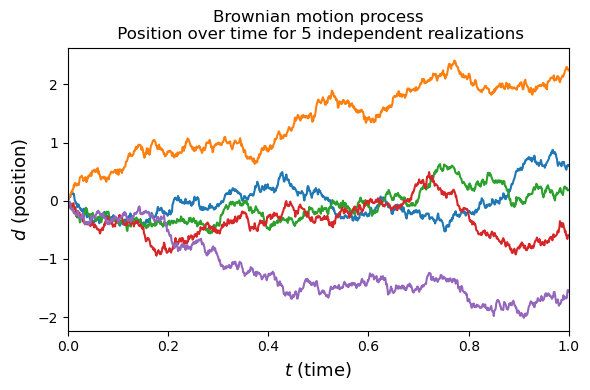

In [37]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 1000
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()
#

In this example we have created 5 different realizations of a random walk. Each realization can be thought of a function giving distance as a function of time ($f(t)=d$). Stochastic processes can be interpreted as a random distribution over functions. Gaussian processes are a stochastic process.

# Gaussian process

Gaussian processes are defined by a mean and covariance between points in the domain:

$f(x)=\mathcal{GP}(m(x),k(x,x'))$

where $m(x)$ is the mean and $k(x,x')$ is a positive definite covariance matrix between all possible pairs in the domain $(x,x')$. 

For some finite subset of points this can be represented as a multivariate normal distribution:

$f(X)=\mathcal{N}(\mu,\Sigma)$

where $\Sigma$ is a covariance matrix linking some finite number of normal distributions. Unlike the multivariate normal (MVN), the GP doesn't have the limitation of a finite number of normals and its mean and covariance are defined by functions. Another way to relate these concepts is to think of a GP as an infinite dimensional MVN. Let's glance at a MVN to remind ourselves of what these look like.

In [38]:
def gen_Gaussian_samples(mu, sigma, N=200):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    """
#    D = mu.shape[0]
#    samples = np.zeros((N,D))
#    for i in np.arange(N):
    samples = np.random.multivariate_normal(mean=mu, cov=sigma,size=N)
    return samples.copy()
def plt_gauss_contours(mu,sigma):
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, sigma)
    plt.contourf(x, y, rv.pdf(pos),cmap='binary')
    plt.xlim(-2,2); plt.ylim(-2,2)
    print(samples.shape)    

We can take a first look at a pair of uncorrelated gaussians. Red dots are individual realizations drawn from the MVN. Note that this is equivalent to the Brownian motion example above.

(30, 2)


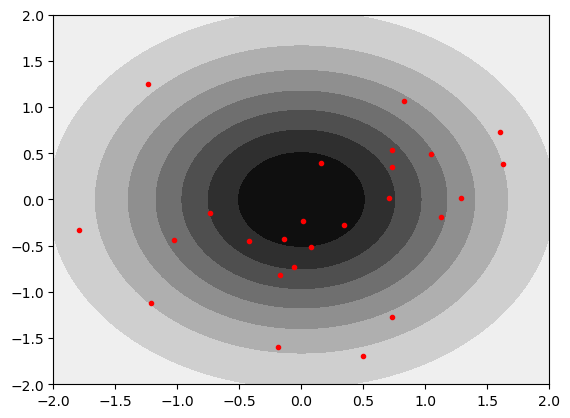

In [39]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.0
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
samples = gen_Gaussian_samples(mu,sigma,N=30) 
plt_gauss_contours(mu,sigma)
plt.plot(samples[:,0],samples[:,1],'.r')


Let's try making the gaussians correlated by changing the off diagonals of the covariance matrix.

(30, 2)


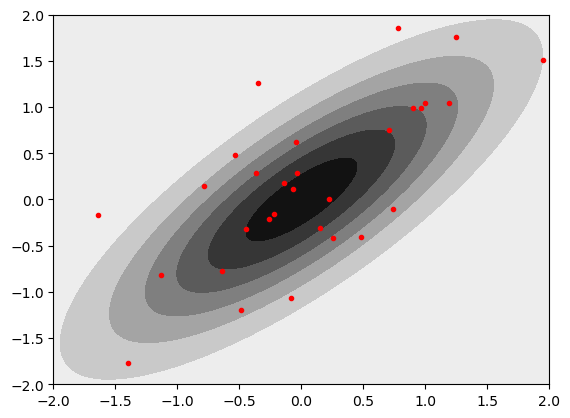

In [40]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.8
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
samples = gen_Gaussian_samples(mu,sigma,N=30) 
plt_gauss_contours(mu,sigma)
plt.plot(samples[:,0],samples[:,1],'.r')


We can think about conditioning and marginalizing the multivariate normal. Visually, this is drawing a line through the distribution or summing to one axis. To illustrate this quickly and dirtily (but hopefully transparently) we can just generate a lot of samples, bin them, and plot them. 

(30, 2)


Text(0.5, 1.0, 'Conditional')

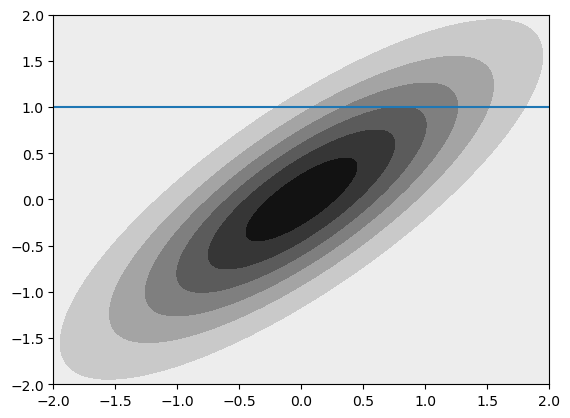

<Figure size 600x600 with 0 Axes>

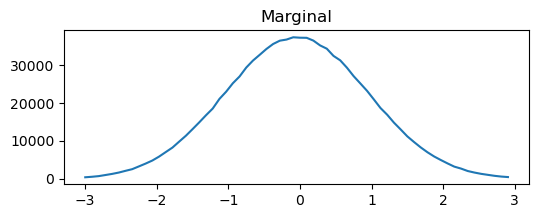

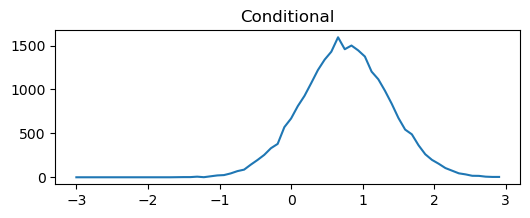

In [41]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.8
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
plt_gauss_contours(mu,sigma)
plt.axhline(1)
samples = gen_Gaussian_samples(mu,sigma,N=1000000) 
plt.figure(figsize=(6,6))
binned=binned_statistic_2d(samples[:,0],samples[:,1],samples[:,1],statistic='count',bins=[np.linspace(-3,3,60),np.linspace(-3,3,65)])
plt.figure(figsize=(6,2))
plt.plot(binned[2][0:-1],sum(binned[0],1))
plt.title('Marginal')
plt.figure(figsize=(6,2))
plt.plot(binned[2][0:-1],binned[0][np.argmin(abs(binned[1]-1))])
plt.title('Conditional')


From this simplified example we can begin to see the utility of the covariance matrix in setting the type of realization we will get from our GP. This example just has two points (so we can plot it), but we can imagine extending this to an infinite dimensional MVN (GP) by having a function that defines the covariance rather than a discrete matrix. In the example above you can play around with the conditional and marginal distributions by altering the covariance.

# Kernel function

The function we use to set our covariances act as a prior on joint variability of the GP random variables. The covariance is represented by a kernel $k(x_a,x_b)$. An easy example to conceptualize how the kernel acts as a prior is to consider the simplest possible case where $k(x_a,x_b)=0$. This will have a much different behavior than any other kernel.  Here, we can consider the exponentiated quadratic or radial basis function (RBF) kernel to get an idea of how these work

$k(x_a,x_b)=exp(\frac{-1}{\sigma^2} ||x_a-x_b||^2)$

One thing you will notice is that we have introduced a tunable parameter in the kernel: $\sigma$. This sets the fall off in covariance between points. Many other kernels are possible and have similar tunable parameters. We will fit these parameters later when we talk about regression. For now we can just look at the RBF. For these notes we can just manually define these, but you will nearly always use a package that does all of this for you.

In [48]:
def exponentiated_quadratic(xa, xb,sigma=1):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -1/(2*sigma**2) * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

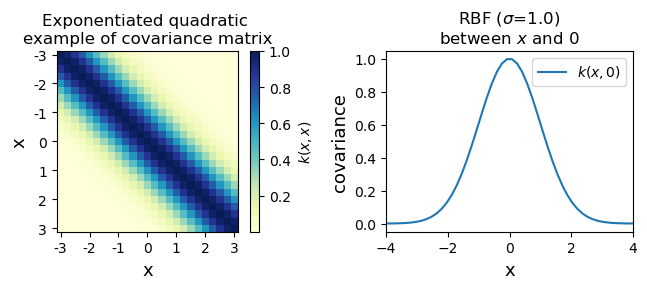

In [68]:
SIGMA=np.sqrt(1) ### CHANGE TO VARY SIGMA PARAMETER



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X,SIGMA)
# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=50), 1)
zero = np.array([[0]])
Σ0 = exponentiated_quadratic(X, zero,VARIANCE)
# Make the plots
ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'RBF ($\sigma$=' +str(SIGMA) +')\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()
#

The kernel gives a covariance for all possible combinations of $x$. We can vary the covariance behavior by altering the code above. As you can see, the covariance between points goes to 1 when they are right on top of each other and then tails off. You can alter that tailing off by changing the $\sigma$ in the kernel. 

# Sampling from the gaussian process

Before you get too worried about an infinite dimensional normal distribution, we can just sample our infinite dimensional GP at a finite set of points. Analogously, there are infinite values in y=mx+b, but we just evaluate it at a limited number of points. 

Effectively, we can evaluate at some finite number of points $X$. This looks like $y=f(X)$. What we are doing is taking the marginal distribution of our $\mathcal{GP}$. This is effectively, $y~\mathcal{N}(\mu,\Sigma)$ where the mean vector is $\mu=m(X)$ and the covariance matrix is $\Sigma=k(X,X)$

We can take a look at drawing a few priors from the RBF kernel above. We aren't fitting anything, we are just asking the question what a few samples from from the GP look like. Ultimately, we are going to be tossing out every option in our infinite prior space that doesn't look like our observations, but for now let's just mess around with with priors to get a feeling of what these look like...

We are going to evaluate 5 priors at 41 x points, so we have a 41-D MVN. We set $\mu=0$ so $\mathcal{N}(0,\Sigma)$ and $X=[X_1,...X_{41}]$. We learn about \Sigma from our RBF kernel above. Keep in mind, we set our $\sigma$ in the RBF kernel. 

In [91]:
SIGMA=1 ## CHANGE TO AFFECT SIGMA PARAMETER
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X, SIGMA)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

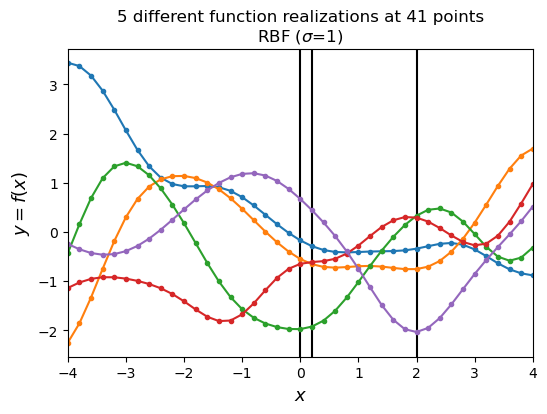

In [92]:
plt.figure(figsize=(6, 4))
plt.axvline(0,c='k',zorder=-10);plt.axvline(0.2,c='k',zorder=-10);plt.axvline(2,c='k',zorder=-10)
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'RBF ($\sigma$=' +str(SIGMA) + ')'))
plt.xlim([-4, 4])
plt.show()
#

These priors have some interesting properties. They look kind of physical (and in fact they are a representation of AR1 processes, which occur frequently in nature). We can change how they look by changing the $\sigma$ parameter in the code below. Try setting it to some other values and replotting your functions.

Let's revisit our earlier example and look at some marginal distributions corresponding to the black vertical lines in the figure above. We can look at the underlying distribution that we are sampling from as well as individual priors drawn from the distribution. Note that the two black lines right next to each other are very strongly correlated, while looking at the black line at zero and 2 are pretty weakly correlated by comparison. Try changing $\sigma$ in the code above to get a different looking correlation. This is changing the kernel used to generate $\Sigma$

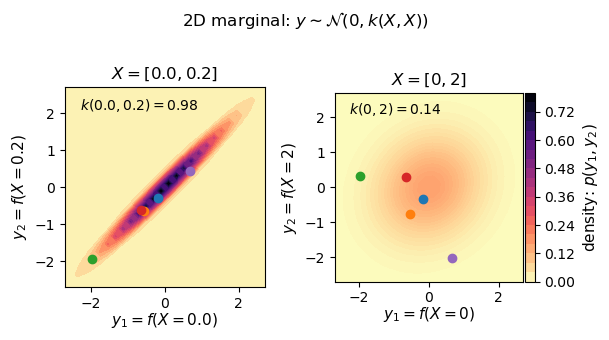

In [93]:
# Show marginal 2D Gaussians

def generate_surface(mean, covariance, surface_resolution):
    """Helper function to generate density surface."""
    x1s = np.linspace(-5, 5, num=surface_resolution)
    x2s = np.linspace(-5, 5, num=surface_resolution)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((surface_resolution, surface_resolution))
    # Fill the cost matrix for each combination of weights
    for i in range(surface_resolution):
        for j in range(surface_resolution):
            pdf[i,j] = scipy.stats.multivariate_normal.pdf(
                np.array([x1[i,j], x2[i,j]]), 
                mean=mean, cov=covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

surface_resolution = 50  # Resolution of the surface to plot
fig = plt.figure(figsize=(6.2, 3.5)) 
gs = gridspec.GridSpec(1, 2)
ax_p1 = plt.subplot(gs[0,0])
ax_p2 = plt.subplot(gs[0,1], sharex=ax_p1, sharey=ax_p1)

# Plot of strong correlation
X_strong = np.array([[0], [0.2]])
μ = np.array([0., 0.])
Σ_strong = exponentiated_quadratic(X_strong, X_strong,SIGMA)
y1, y2, p = generate_surface(μ, Σ_strong, surface_resolution=surface_resolution)
# Plot bivariate distribution
con1 = ax_p1.contourf(y1, y2, p, 25, cmap=cm.magma_r)
ax_p1.set_xlabel(
    f'$y_1 = f(X={X_strong[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p1.set_ylabel(
    f'$y_2 = f(X={X_strong[1,0]})$', 
    fontsize=11)
ax_p1.axis([-2.7, 2.7, -2.7, 2.7])
ax_p1.set_aspect('equal')
ax_p1.text(
    -2.3, 2.1, 
    (f'$k({X_strong[0,0]}, {X_strong[1,0]}) '
     f'= {Σ_strong[0,1]:.2f}$'), 
    fontsize=10)
ax_p1.set_title(
    f'$X = [{X_strong[0,0]}, {X_strong[1,0]}]$ ', 
    fontsize=12)
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_02_index = np.where(np.isclose(X, 0.2))
y_strong = ys[:,[X_0_index[0][0], X_02_index[0][0]]]
# Show samples on surface
for i in range(y_strong.shape[0]):
    ax_p1.plot(y_strong[i,0], y_strong[i,1], marker='o')

# Plot weak correlation
X_weak = np.array([[0], [2]])
μ = np.array([0., 0.])
Σ_weak = exponentiated_quadratic(X_weak, X_weak,SIGMA)
y1, y2, p = generate_surface(μ, Σ_weak, surface_resolution=surface_resolution)
# Plot bivariate distribution
con2 = ax_p2.contourf(y1, y2, p, 25, cmap=cm.magma_r)
con2.set_cmap(con1.get_cmap())
con2.set_clim(con1.get_clim())
ax_p2.set_xlabel(
    f'$y_1 = f(X={X_weak[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p2.set_ylabel(
    f'$y_2 = f(X={X_weak[1,0]})$', 
    fontsize=11)
ax_p2.set_aspect('equal')
ax_p2.text(
    -2.3, 2.1, 
    (f'$k({X_weak[0,0]}, {X_weak[1,0]}) '
     f'= {Σ_weak[0,1]:.2f}$'), 
    fontsize=10)
ax_p2.set_title(
    f'$X = [{X_weak[0,0]}, {X_weak[1,0]}]$', 
    fontsize=12)
# Add colorbar
divider = make_axes_locatable(ax_p2)
cax = divider.append_axes('right', size='5%', pad=0.02)
cbar = plt.colorbar(con1, ax=ax_p2, cax=cax)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=11)
fig.suptitle('2D marginal: $y \sim \mathcal{N}(0, k(X, X))$')
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_2_index = np.where(np.isclose(X, 2.))
y_weak = ys[:,[X_0_index[0][0], X_2_index[0][0]]]
# Show samples on surface
for i in range(y_weak.shape[0]):
    ax_p2.plot(y_weak[i,0], y_weak[i,1], marker='o')

plt.tight_layout()
plt.show()
#

# Fitting with Gaussian Process Regression

Ok great- we can pull priors from an infinite dimension MVN. We can set the way that our MVN works with kernels. Obviously we want to do the thing it says on the can: regression. Doing this is conceptually easy. We throw out all of our infinte priors that don't intersect with our fit data.  The GP is our prior based on our choice of kernels and we are going to build a posterior that agrees with some observations (observations of $y$ at some selection of $X$). We can then use that posterior function to predict $y$ at some new set of $X$

Let's work through the math (briefly). Let's say we have $n_1$ data points we have observed that we will be training our fit with $(X_1,y_1)$. We want to get predictions at some new set of $n_2$ points ($y_2=f(X_2)$). This is our posterior distribution $p(y_2|y_1,X_1,X_2)$. Keep in mind that $y_1$ and $y_2$ are both coming from the same MVN.

$\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} \sim \mathcal{N}($$\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}$$,$$\begin{bmatrix} \Sigma_{11}, \Sigma_{12} \\ \Sigma_{21}, \Sigma_{22} \end{bmatrix}$$)$

Where

$\mu_1=m(X_1) ; (n_1\times 1)$

$\mu_2=m(X_2) ; (n_2\times 1)$

$\Sigma_{11}=k(X_1,X_1) ; (n_1\times n_1)$

$\Sigma_{22}=k(X_2,X_2) ; (n_2\times n_2)$

$\Sigma_{12}=k(X_1,X_2) ; (n_1\times n_2)$ (note that symetric $\Sigma_{21}=\Sigma_{12}^T$)


So we are drawing values from some MVN that has been split into two chunks (1 and 2) and we can now think about getting our conditional distribution based on the data we have in 1.

$p(y_2|y_1,X_1,X_2)=\mathcal{N}(\mu_{2|1},\Sigma_{2|1})$

A variety of GP textbooks give the calculation for the conditional mean and covariance matrix (e.g. Rasmussen and Williams) and they are:

$\mu_{2|1}=\mu_2+\Sigma_{2|1}\Sigma_{1|1}^{-1}(y_1-\mu_1)$ 

if $\mu=0$ then this is $\Sigma_{2|1}\Sigma_{1|1}^{-1} y_1$

$\Sigma_{2|1}=\Sigma_{2|2}+\Sigma_{2|1}\Sigma_{1|1}^{-1}\Sigma_{1|2}$

Since $\Sigma_{1|1}=\Sigma_{1|1}^T$ we can write this as

$\mu_{2|1}=(\Sigma_{1|1}^{-1}\Sigma_{1|2})^T(y_1)$ 

and

$\Sigma_{2|1}=\Sigma_{2|2}+(\Sigma_{1|1}^{-1}\Sigma_{1|2})^T\Sigma_{1|2}$

This means we can make predictions of the mean and the variance of our points at $X_2$ using, respectively, $\mu_{2|1}$ and the diagonal of $\Sigma_{2|1}$. Note that our prediction of $\mu_2|1$ is based on weighting our observations $y_1$ by our kernel. 

While you will use some package like gpflow, sklearn, etc. to do this in practice, we can use scipy to calculate this all.

In [96]:
def GP(X1, y1, X2, kernel_func,sigma):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1,sigma)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2,sigma)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2,sigma)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [105]:
f_sin = lambda x: (np.sin(x)).flatten()
SIGMA=np.sqrt(1)
n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic,SIGMA)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

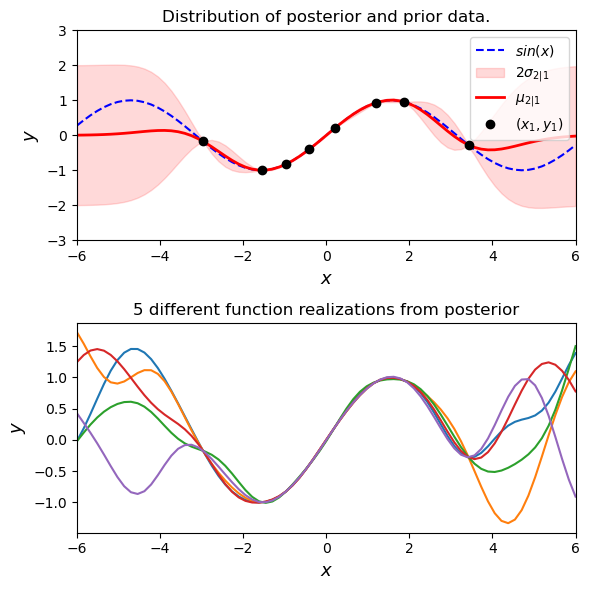

In [106]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

One again note that we have just set the parameters in the kernel. You can change the $\sigma$ in the kernel by change the code above to explore different potential kernel configurations.

GRP carries an estimate of its own fitting uncertainty with it. This is shown as red shading in the plot above. Since these are just MVNs the calculation of the confidence interval is just 1.96 times the standard deviation. We plot a few different realizations that fit through our points in the plot below.

# Imperfect (noisy) observations

You will notice that we have forced our infinite possible priors to fit through the observations perfectly. Realistically, observations will have some noise to them. If we model our observation noise as a white noise 

$f(X_1)=y_1+\epsilon$

this can be added to the diagonal of our covariance

$\Sigma_{11}=k(X_1,X_1) +\sigma_{\epsilon}^2 I$

updating the code to handle some noise in the training data

In [108]:
def GP_noise(X1, y1, X2, kernel_func, sigma_noise):

    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((sigma_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [111]:
# Compute the posterior mean and covariance

sigma_noise = 0.3  # The standard deviation of the noise

# Add noise kernel to the samples we sampled previously
y1 = y1 + ((sigma_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, sigma_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

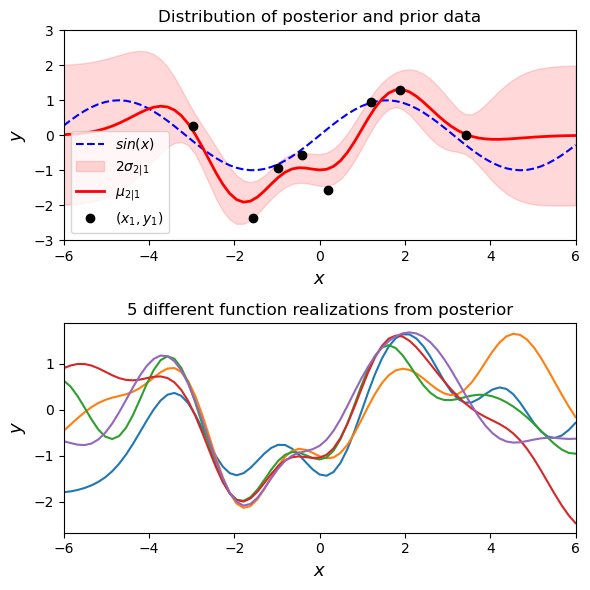

In [112]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

Now we don't have to fit all of our posterior realizations perfectly through the data points because we have some noise in our observations. You can change the amount of noise that is being allowed in the observations above. One way of viewing this is that we have added an additional kernel to the RBF kernel we have been using. In fact, you can add (and multiply) kernels together to fit complex functions. 

This is the underlying GPR process. Like many things in data analysis, there are lots of packages we can use to simplify this process dramatically. We can use lots of different kernels- one useful resource presenting many commonly used kernels is David Duvenaud's kernel cookbook (https://www.cs.toronto.edu/~duvenaud/cookbook/).

# Using SciKit-Learn to forecast MLO CO2

Now that we feel a bit more comfortable with what GPR is doing under the hood we can try a practical, but simple, example. Many packages for GPR exist in python and sklearn is only one of them. We follow the example here:
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

First we import the CO2 data and process it - because of spotty sampling there is some code dropping months where no data exists

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


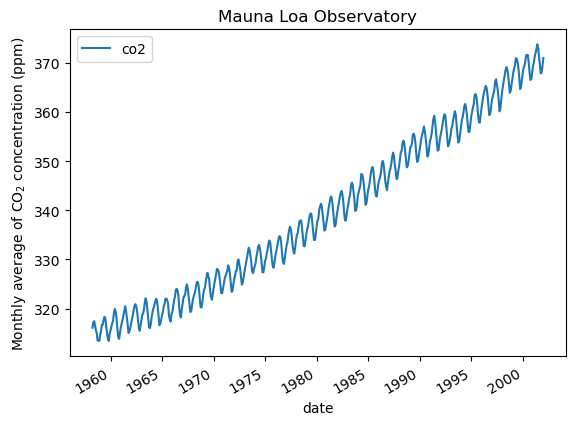

In [122]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
#co2_data.head()

try:
    co2_data_resampled_monthly = co2_data.resample("ME")
except ValueError:
    # pandas < 2.2 uses M instead of ME
    co2_data_resampled_monthly = co2_data.resample("M")


co2_data = co2_data_resampled_monthly.mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Mauna Loa Observatory"
)
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

Great- now we recall from our super simple example fitting a sine wave above that we need to actually make some user decisions deciding on a kernel. Let's start with the RBF kernel first. We can set the length scale and amplitude of our RBF kernel as a first guess.

In [124]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
co2_kernel = (
    long_term_trend_kernel )

Let's try fitting our data

In [125]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50))

In [126]:
import datetime

import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

17.1**2 * RBF(length_scale=1e-05)

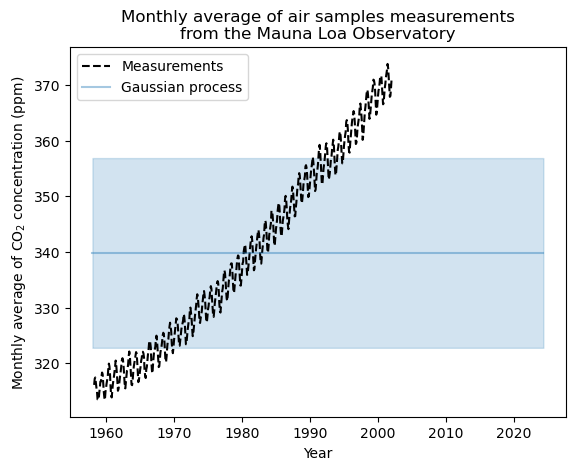

In [128]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

gaussian_process.kernel_

Not great... We printed out the hyper parameters above and the length scale is really really short for our RBF kernel as well. Let's go back to the drawing board and try making a kernel that deals with the following:

The interannual growth of CO2
The seasonal variability in CO2
The noise in our measurements
Irregularities in our measurements from month to month

In [129]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [130]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [131]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [132]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Note that the different kernel parameters have been set during fitting. This is done by optimizing the possible kernels using log liklehood. A thorough exploration of this is given here: https://peterroelants.github.io/posts/gaussian-process-kernel-fitting/ but sklearn does all this for us under the hood...

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

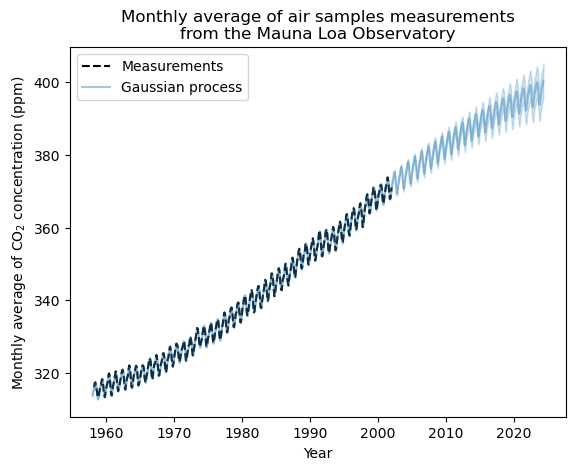

In [134]:
y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

gaussian_process.kernel_

Much better! We have given the fit the ability to not perfectly intersect with every training data point (white noise) as well as the ability to fit trends (RBF), seasonal cycles (periodic), and other little wiggles in the data (rational quadratic).

Just for fun, we can try some other kernels. We used the set of kernels suggested in sklearn, and that worked well because there were lots of ways to fit the dataset and we had some apriori knowledge of how things like plant draw down work. What if we just have a trend and don't need to fit the data through the points exactly?

In [139]:
co2_kernel = (
    long_term_trend_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.236**2 * RBF(length_scale=1e-05) + 41.3**2 * RBF(length_scale=47.9) + WhiteKernel(noise_level=4.37)

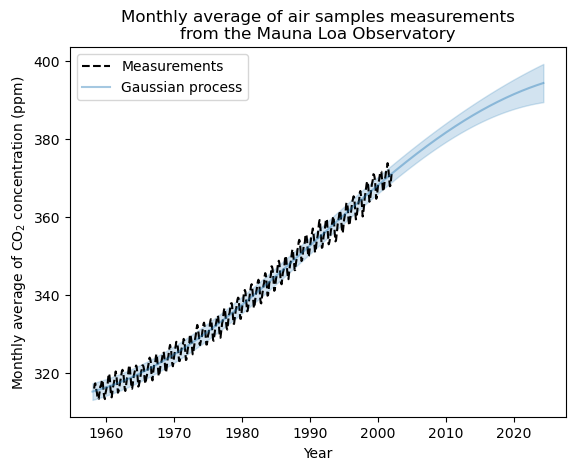

In [140]:
y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

gaussian_process.kernel_

It doesn't do all that badly. It doesn't have the flexibility to get the seasonal cycle, but it does get the trend in the data. We can see that as the prediction gets farther out the uncertainty increases, just like we expect.

There are lots of other utilities for GPR beyond the examples shown here. Like any regression model, you can fit multi-dimensional data. One thing that GPR tends to do very well at is working in the low-data regime- and without a white noise kernel we say it actually kind of struggles in the high data regime. One of its key strengths is carrying a prediction uncertainty with it.